Make sure to set the runtime to GPU: Runtime -> Change runtime type -> T4 GPU

You can upload your own images, then change the relevant code cells to load it and send it through the model.

In [32]:
# install the intrinsic decomposition repo from github
!pip install https://github.com/compphoto/Intrinsic/archive/main.zip

  Using cached https://github.com/compphoto/Intrinsic/archive/main.zip
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/MiDaS (to revision master) to /tmp/pip-install-_pjhyf_1/altered-midas_ac18ebffabd846a692ad4cf7a48fd082
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/MiDaS /tmp/pip-install-_pjhyf_1/altered-midas_ac18ebffabd846a692ad4cf7a48fd082
  Resolved https://github.com/CCareaga/MiDaS to commit fb51e3af860d9430e9aaeb1d30edd3b6e2ac0538
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CCareaga/chrislib (to revision main) to /tmp/pip-install-_pjhyf_1/chrislib_53f3682026244097b5409cc1ec113654
  Running command git clone --filter=blob:none --quiet https://github.com/CCareaga/chrislib /tmp/pip-install-_pjhyf_1/chrislib_53f3682026244097b5409cc1ec113654
  Resolved https://github.com/CCareaga/chrislib to commit 9a4c63f5fc5e7bbe62288f2777c527b706eb04d0
  Preparing metadata (setup.py) ... done


In [33]:
import torch

# import some helper functions from chrislib (will be installed by the intrinsic repo)
from chrislib.general import show, view, invert
from chrislib.data_util import load_from_url

# import model loading and running the pipeline
from intrinsic.pipeline import load_models, run_pipeline

In [45]:
from datetime import datetime
from PIL import Image
from google.colab import files
import os

print("Imported libraries for saving images.")

Imported libraries for saving images.


In [34]:
# download the pretrained weights and return the model (may take a bit to download weights the first time)
intrinsic_model = load_models('v2')

loading v2 weights


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


In [35]:
# run the image through the pipeline (runs all stages)
result = run_pipeline(
    intrinsic_model,
    img,
    device='cuda'
)

In [36]:
img = result['image']
alb = view(result['hr_alb']) # gamma correct the estimated albedo
dif = 1 - invert(result['dif_shd']) # tonemap the diffuse shading
res = result['residual']

In [37]:
from google.colab import files
from PIL import Image
import io
print("Imported necessary libraries for file upload.")

Imported necessary libraries for file upload.


In [38]:
import numpy as np

uploaded = files.upload()

# Initialize img1 and img2
img1 = None
img2 = None

image_files = list(uploaded.keys())

if len(image_files) >= 2:
    # Process the first image
    img_bytes1 = uploaded[image_files[0]]
    pil_img1 = Image.open(io.BytesIO(img_bytes1)).convert('RGB') # Ensure RGB format
    img1 = torch.from_numpy(np.array(pil_img1)).float() / 255.0 # Convert to numpy, then tensor and normalize
    img1 = img1.permute(2, 0, 1) # Permute to C, H, W

    # Process the second image
    img_bytes2 = uploaded[image_files[1]]
    pil_img2 = Image.open(io.BytesIO(img_bytes2)).convert('RGB') # Ensure RGB format
    img2 = torch.from_numpy(np.array(pil_img2)).float() / 255.0 # Convert to numpy, then tensor and normalize
    img2 = img2.permute(2, 0, 1) # Permute to C, H, W

    print(f"Successfully uploaded and loaded '{image_files[0]}' and '{image_files[1]}' into img1 and img2.")
elif len(image_files) == 1:
    # Process the first image
    img_bytes1 = uploaded[image_files[0]]
    pil_img1 = Image.open(io.BytesIO(img_bytes1)).convert('RGB') # Ensure RGB format
    img1 = torch.from_numpy(np.array(pil_img1)).float() / 255.0 # Convert to numpy, then tensor and normalize
    img1 = img1.permute(2, 0, 1) # Permute to C, H, W
    print(f"Successfully uploaded and loaded '{image_files[0]}' into img1. Please upload another image if img2 is required.")
else:
    print("No images uploaded.")

Saving view1.png to view1 (3).png
Successfully uploaded and loaded 'view1 (3).png' into img1. Please upload another image if img2 is required.


In [39]:
import numpy as np
import skimage.transform as st
from google.colab import files
from PIL import Image
import io
import torch # Already imported, but good to ensure explicitly if code blocks are moved/reorganized

# Helper functions from chrislib and intrinsic were already imported globally.
print("Consolidated new libraries imported.")

Consolidated new libraries imported.


Intrinsic decomposition run on img1 successfully.
Extracted and prepared components for img1: img1_display, alb1, dif1, res1.
Calculated specular-free image for img1 (spec_free_img1).
Displayed original, specular-free, and albedo images for img1.


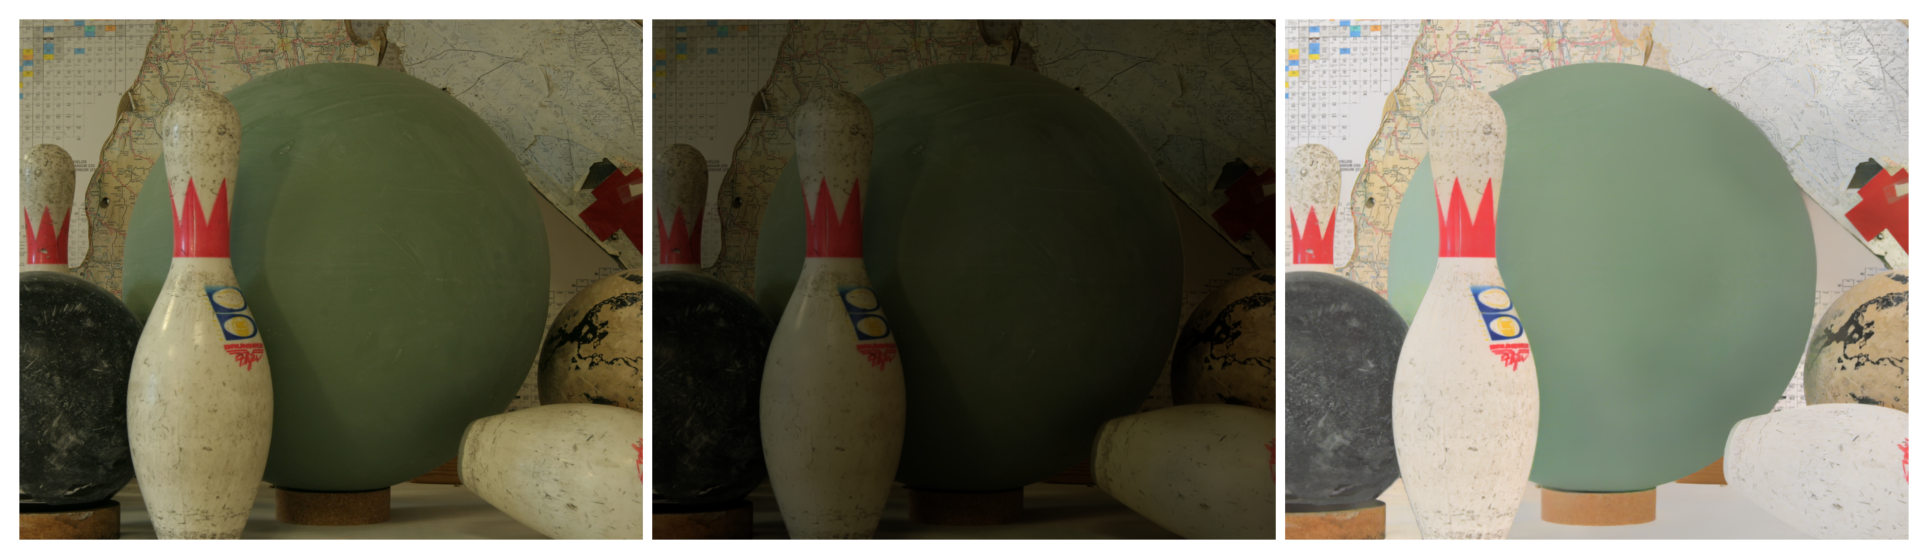

In [40]:
if img1 is not None:
    # Run intrinsic decomposition on img1
    result1 = run_pipeline(
        intrinsic_model,
        img1.permute(1, 2, 0).cpu().numpy(), # Convert from (C, H, W) tensor to (H, W, C) numpy array
        device='cuda',
        resize_conf=None
    )
    print("Intrinsic decomposition run on img1 successfully.")

    # Extract and prepare components for img1
    img1_display = img1.permute(1, 2, 0).cpu().numpy() # Convert from (C, H, W) tensor to (H, W, C) numpy array for display
    alb1 = view(result1['hr_alb']) # gamma correct the estimated albedo for img1
    dif1 = 1 - invert(result1['dif_shd']) # tonemap the diffuse shading for img1
    res1 = result1['residual']
    print("Extracted and prepared components for img1: img1_display, alb1, dif1, res1.")

    # Calculate specular-free image for img1
    spec_free_img1 = alb1 * dif1
    print("Calculated specular-free image for img1 (spec_free_img1).")

    # Resize components for display if necessary and display results
    target_h, target_w, _ = img1_display.shape
    alb1_resized = st.resize(alb1, (target_h, target_w), anti_aliasing=True)
    spec_free_img1_resized = st.resize(spec_free_img1, (target_h, target_w), anti_aliasing=True)

    show([img1_display, spec_free_img1_resized, alb1_resized], size=(30, 7))
    print("Displayed original, specular-free, and albedo images for img1.")
else:
    print("img1 is not available for processing. Please upload an image first.")

In [41]:
import numpy as np

result1 = run_pipeline(
    intrinsic_model,
    img1.permute(1, 2, 0).cpu().numpy(), # Convert from (C, H, W) tensor to (H, W, C) numpy array
    device='cuda',
    resize_conf=None
)
print("Intrinsic decomposition run on img1 successfully.")

Intrinsic decomposition run on img1 successfully.


In [42]:
img1_display = img1.permute(1, 2, 0).cpu().numpy() # Convert from (C, H, W) tensor to (H, W, C) numpy array for display
alb1 = view(result1['hr_alb']) # gamma correct the estimated albedo for img1
dif1 = 1 - invert(result1['dif_shd']) # tonemap the diffuse shading for img1
res1 = result1['residual']

print("Extracted and prepared components for img1: img1_display, alb1, dif1, res1.")

Extracted and prepared components for img1: img1_display, alb1, dif1, res1.


In [43]:
spec_free_img1 = alb1 * dif1
print("Calculated specular-free image for img1 (spec_free_img1).")

Calculated specular-free image for img1 (spec_free_img1).


Displayed original, specular-free, and albedo images for img1.


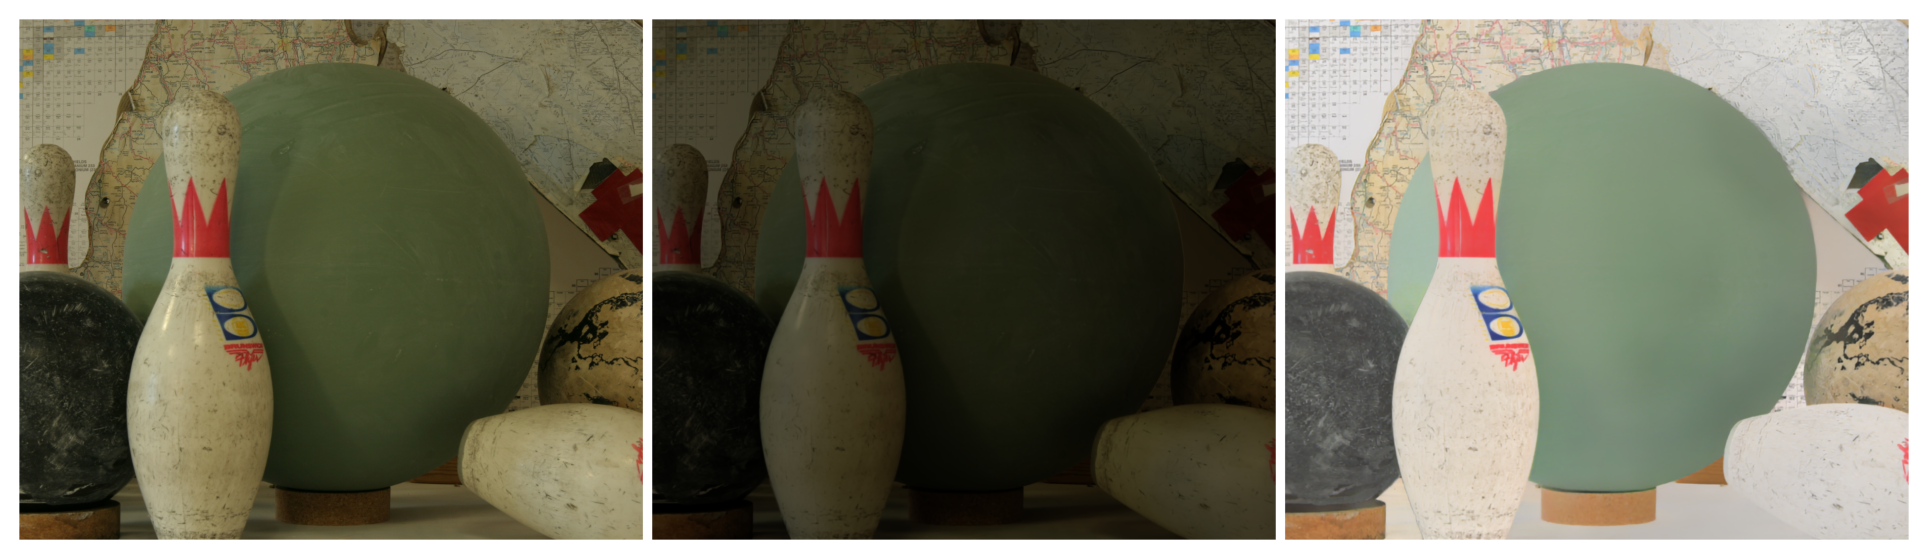

In [44]:
import skimage.transform as st

target_h, target_w, _ = img1_display.shape

# Resize alb1 and spec_free_img1 to match img1_display's dimensions
alb1_resized = st.resize(alb1, (target_h, target_w), anti_aliasing=True)
spec_free_img1_resized = st.resize(spec_free_img1, (target_h, target_w), anti_aliasing=True)

show([img1_display, spec_free_img1_resized, alb1_resized], size=(30, 7))
print("Displayed original, specular-free, and albedo images for img1.")

In [47]:
# Get the original filename without extension
original_filename_base = os.path.splitext(image_files[0])[0]

# Get current date in YYYYMMDD format
current_date = datetime.now().strftime("%Y%m%d")

# Prepare images and their types for saving
images_to_save = [
    (img1_display, "original"),
    (spec_free_img1_resized, "specular-free"),
    (alb1_resized, "albedo")
]

for img_array, img_type in images_to_save:
    # Ensure image data is in 0-255 range and uint8 type for PIL
    img_uint8 = (img_array * 255).astype(np.uint8)

    # Create a PIL Image object
    pil_img = Image.fromarray(img_uint8)

    # Construct the filename
    save_filename = f"{original_filename_base}_{current_date}_{img_type}.png"

    # Save the image to a temporary location and provide a download link
    pil_img.save(save_filename)
    files.download(save_filename)
    print(f"Saved and downloaded: {save_filename}")

print("All requested images have been saved and downloaded.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved and downloaded: view1 (3)_20260122_original.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved and downloaded: view1 (3)_20260122_specular-free.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved and downloaded: view1 (3)_20260122_albedo.png
All requested images have been saved and downloaded.
